In [4]:
# !pip install transformers
# !pip install keras_nlp
# !pip install datasets
# !pip install huggingface-hub huggingface_hub
# !pip install nltk
# !pip install rouge-score rouge
# !pip install evaluate
# !apt install git-lfs
# !pip install sentencepiece

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from datasets import load_dataset, load_metric, load_from_disk
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, AdamWeightDecay, create_optimizer
from transformers.keras_callbacks import PushToHubCallback, KerasMetricCallback
from tensorflow.keras.callbacks import TensorBoard
import evaluate
import nltk
from transformers import pipeline, set_seed
set_seed(42)
from nltk.corpus import stopwords
nltk.download('punkt')

# Only log error messages
import logging
tf.get_logger().setLevel(logging.ERROR)

os.environ["TOKENIZERS_PARALLELISM"] = "True"

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/content/drive/MyDrive/Data_Science/Bigpatent_Summarization/src')
from metrics_evaluation import evaluate_model
from preprocesss import preprocess_function, preprocess_dataset
from tf_datas import prepare_tf_datasets, compile_model, plot_loss

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
from huggingface_hub import notebook_login

notebook_login()

## Loading the dataset

### About Dataset
[BIGPATENT](https://huggingface.co/datasets/big_patent), consisting of 1.3 million records of U.S. patent documents along with human written abstractive summaries. Each US patent application is filed under a Cooperative Patent Classification (CPC) code. There are nine such classification categories:

* a: Human Necessities
* b: Performing Operations; Transporting
* c: Chemistry; Metallurgy
* **d: Textiles; Paper**
* e: Fixed Constructions
* f: Mechanical Engineering; Lightning; Heating; Weapons; Blasting
* g: Physics
* h: Electricity
* y: General tagging of new or cross-sectional technology

I will be working with 1 out of the 9 classification categories due to low compute unit.

In [4]:
df = load_dataset("big_patent", "d")

  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
## saving the data
# df.save_to_disk('/content/drive/MyDrive/Data_Science/Bigpatent_Summarization/d_dataset')

## Loading the data
#df = load_from_disk('/content/drive/MyDrive/Data_Science/Bigpatent_Summarization/d_dataset')

In [5]:
print(df)

DatasetDict({
    train: Dataset({
        features: ['description', 'abstract'],
        num_rows: 10164
    })
    validation: Dataset({
        features: ['description', 'abstract'],
        num_rows: 565
    })
    test: Dataset({
        features: ['description', 'abstract'],
        num_rows: 565
    })
})


In [6]:
df['train'] = df['train'].shuffle(seed=42).select(range(1000))
print(df)

DatasetDict({
    train: Dataset({
        features: ['description', 'abstract'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['description', 'abstract'],
        num_rows: 565
    })
    test: Dataset({
        features: ['description', 'abstract'],
        num_rows: 565
    })
})


## Define Certain Variables

In [7]:
# Maximum length of the input to the model
MAX_INPUT_LENGTH = 1024  

# Minimum length of the output by the model
MIN_TARGET_LENGTH = 5  
# Maximum length of the output by the model
MAX_TARGET_LENGTH = 128 

# Batch-size for training our model
BATCH_SIZE = 8

## T5-Model

### Preprocessing

In [10]:
MODEL_CHECKPOINT = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

if MODEL_CHECKPOINT in ["t5-small", "t5-base", "t5-large", "t5-3b", "t5-11b"]:
    prefix = "summarize: "
else:
    prefix = ""

In [11]:
tokenized_df = preprocess_dataset(df, tokenizer, MAX_INPUT_LENGTH, MIN_TARGET_LENGTH, MAX_TARGET_LENGTH, prefix)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/565 [00:00<?, ? examples/s]

Map:   0%|          | 0/565 [00:00<?, ? examples/s]

In [12]:
tokenized_df["train"]

Dataset({
    features: ['description', 'abstract', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1000
})

In [13]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(MODEL_CHECKPOINT)

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [14]:
# Prepare datasets
tf_train_set, tf_val_set, tf_generation_set = prepare_tf_datasets(tokenized_df["train"],
                                                                  tokenized_df["validation"],
                                                                  BATCH_SIZE,
                                                                  tokenizer,
                                                                  model
                                                                )

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [15]:
# Compile the model
optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01) 
compile_model(model, optimizer)

In [16]:
# pushing the model to tensorflow hub
model_name = MODEL_CHECKPOINT.split("/")[-1]
push_to_hub_model_id = f"{model_name}-finetuned-Big-Patent"

tensorboard_callback = TensorBoard(log_dir="./summarization_model_save/logs")

push_to_hub_callback = PushToHubCallback(
    output_dir="./summarization_model_save",
    tokenizer=tokenizer,
    hub_model_id=push_to_hub_model_id,
)

Cloning https://huggingface.co/Jammal7/t5-small-finetuned-Big-Patent into local empty directory.


### Training the Model

In [17]:
metric = "rouge"
evaluation_result = evaluate_model(tokenizer, metric)

In [18]:
metric_callback = KerasMetricCallback(
    evaluation_result, eval_dataset=tf_generation_set, predict_with_generate=True, use_xla_generation=True
)

callbacks = [metric_callback, tensorboard_callback, push_to_hub_callback]

history = model.fit(x=tf_train_set, validation_data=tf_val_set, epochs=12, callbacks=callbacks)

Epoch 1/12
125/125 [==============================] - 195s 1s/step - loss: 2.9656 - val_loss: 2.5362 - rouge1: 18.2315 - rouge2: 7.8614 - rougeL: 14.6951 - rougeLsum: 15.9560 - gen_len: 19.0000
Epoch 2/12
125/125 [==============================] - 161s 1s/step - loss: 2.6049 - val_loss: 2.4231 - rouge1: 19.5541 - rouge2: 8.4930 - rougeL: 15.5832 - rougeLsum: 17.0795 - gen_len: 19.0000
Epoch 3/12
125/125 [==============================] - 160s 1s/step - loss: 2.5178 - val_loss: 2.3822 - rouge1: 20.4223 - rouge2: 9.3220 - rougeL: 16.5206 - rougeLsum: 17.9410 - gen_len: 19.0000
Epoch 4/12
125/125 [==============================] - 163s 1s/step - loss: 2.4704 - val_loss: 2.3513 - rouge1: 21.2289 - rouge2: 9.9712 - rougeL: 17.3220 - rougeLsum: 18.6925 - gen_len: 19.0000
Epoch 5/12
125/125 [==============================] - 161s 1s/step - loss: 2.4296 - val_loss: 2.3318 - rouge1: 21.5971 - rouge2: 10.4897 - rougeL: 17.8921 - rougeLsum: 19.1858 - gen_len: 19.0000
Epoch 6/12
125/125 [=========

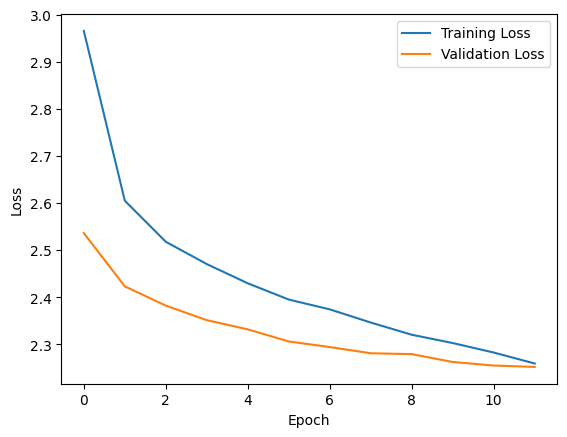

In [19]:
# Plot the loss
plot_loss(history)

### Inference

In [20]:
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM

model_name = 'Jammal7/t5-small-finetuned-Big-Patent'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name)

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at Jammal7/t5-small-finetuned-Big-Patent.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [21]:
document = df['test'][5]['description']
if 't5' in model_name: 
    document = "summarize: " + document
tokenized = tokenizer([document], return_tensors='np')
out = model.generate(**tokenized, max_length=128)

Token indices sequence length is longer than the specified maximum sequence length for this model (5684 > 512). Running this sequence through the model will result in indexing errors


In [22]:
with tokenizer.as_target_tokenizer():
    print(tokenizer.decode(out[0]))

<pad> A cylindrical bearing for a pressure diffuser comprises a plurality of segments of the cylindrical bearing and a second annular section formed of a soft material, which is softer than the hard material; seating the screen assembly with the cylindrical bearing in the lower region of the pressure diffuser; and a second annular section formed of a soft material, which is softer than the hard material; and a second region formed of a soft material, wherein as the soft material is softer than the hard material, and a</s>


## Text Summarization Pipeline

In [23]:
sample_text = df['test'][5]['description'][:1988]

In [24]:
sample_text

'RELATED APPLICATION \n       [0001]    This applications claims priority to U.S. Provisional Patent Application Ser. No. 61/140,467 filed Dec. 23, 2008, the entirety of which application is incorporated by reference. \n     \n    \n     BACKGROUND \n       [0002]    The invention disclosed herein relates generally to pressure diffusers for washing pulp and particularly relates to upper and lower cylindrical bearings between a moving screen assembly and stationary bearing cylinders in the pressure diffuser. \n         [0003]    The term “pulp” generally refers to comminuted cellulosic material, such as wood chips that have been processed in a digester to separate the fibers in the wood. Chemicals, e.g., liquor, are injected into the digester vessel to process the pulp. After the pulp is discharged from the digester vessel, the pulp may have residual amounts of chemicals. \n         [0004]    The pulp flow from the digester vessel to a pressurized diffuser that washes the pulp to remove

### BART

In [25]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)

In [26]:
pipe_out

[{'summary_text': 'This applications claims priority to U.S. Provisional Patent Application Ser. No. 61/140,467 filed Dec. 23, 2008. The term “pulp” generally refers to comminuted cellulosic material, such as wood chips that have been processed in a digester to separate the fibers in the wood.'}]